In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.append('./analysis/')

%load_ext autoreload
%autoreload 2
import utils
from utils import RECENT_DATE_THRESHOLD

In [2]:
metadata = pd.read_json(os.path.join(utils.PROCESSED_DATA_DIR, 'cs_stat_metadata_clusters.json'),
                        orient='records', lines=True,
                        dtype={'id': str})
metadata['v1_date'] = pd.to_datetime(metadata['v1_date'], unit='ms')

In [3]:
START_YEAR_FOR_LLM_LINE_PLOT = 2018

plt.rcParams["font.family"] = "Arial CE"
plt.rcParams["font.size"] = 12

In [5]:
max_date_in_2023 = metadata['v1_date'].max()
corresponding_date_in_2022 = max_date_in_2023 - pd.DateOffset(years=1)
idxs_2023 = metadata['v1_date'].dt.year == 2023
idxs_2022 = (metadata['v1_date'].dt.year == 2022) & (metadata['v1_date'].map(lambda x:x <= corresponding_date_in_2022))

col = 'mentions_LM_keyword'
print("Increase in {} from 2022 to 2023 (matching on time period)".format(col))
print('2022 rate: {} 2023 rate: {} ratio: {}'.format(metadata.loc[idxs_2022, col].mean(), metadata.loc[idxs_2023, col].mean(), metadata.loc[idxs_2023, col].mean() / metadata.loc[idxs_2022, col].mean()))

Increase in mentions_LM_keyword from 2022 to 2023 (matching on time period)
2022 rate: 0.039001532887402456 2023 rate: 0.09470411411057408 ratio: 2.4282151776953267


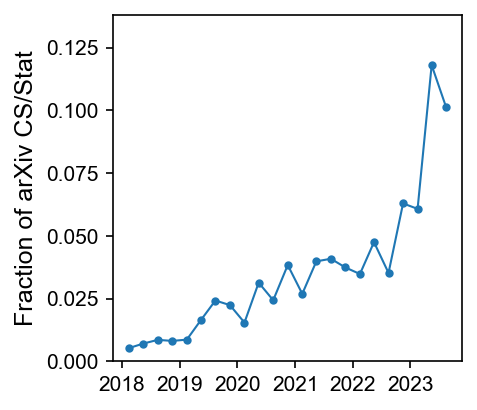

In [27]:
from datetime import datetime

d = metadata.copy()
prevalence_col = 'mentions_LM_keyword'
date_col = 'v1_date'
ylabel='Fraction of arXiv CS/Stat'
time_unit_to_group_by='quarter'
use_log_scale=False

plt.figure(figsize=(3, 3), dpi=150)
assert time_unit_to_group_by in ['month', 'quarter', 'year']
if time_unit_to_group_by == 'month':
    d['time_unit_to_group_by'] = d[date_col].apply(lambda x: datetime(x.year, x.month, 15)) # group by year and month, plot at middle of each month
elif time_unit_to_group_by == 'quarter':
    d['time_unit_to_group_by'] = d[date_col].apply(lambda x: datetime(x.year, 3 * ((x.month - 1) // 3) + 2, 15))
elif time_unit_to_group_by == 'year':
    d['time_unit_to_group_by'] = d[date_col].apply(lambda x: datetime(x.year, 6, 15))
    
timeseries = d.groupby('time_unit_to_group_by')[prevalence_col].mean()
plt.plot(timeseries.index, timeseries, marker='o', markersize=3, linewidth=1)

plt.ylabel(ylabel, fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

if use_log_scale:
    plt.yscale('log')
    plt.ylim(1e-4, 0.5)
else:
    plt.ylim(0, timeseries.max()+0.02)
    
plt.savefig('./analysis/figures/supp_timeseries_overall_incidence.pdf', bbox_inches="tight", dpi=300)

### Fastest-growing topics on all of arXiv cs/stat

In [3]:
metadata['post_2023'] = (metadata['v1_date'] >= RECENT_DATE_THRESHOLD)

recent_topic_df = utils.get_topic_counts_by_binary_variable(metadata, 'post_2023')
recent_topic_df.head(10)

,topic,ratio,count_true,count_false,p_topic_if_true,p_topic_if_false,p_chi2
52,Multimodal Learning and Generation,1.955956,"(807, 67864)","(2130, 350352)",0.011891,0.006080,1.160648e-61
54,NLP & Language Generation,1.793566,"(1406, 67864)","(4047, 350352)",0.020718,0.011551,1.450756e-82
39,Knowledge Graphs and Reasoning,1.768427,"(1078, 67864)","(3147, 350352)",0.015885,0.008982,1.051073e-60
94,Transformers & Language Models,1.735949,"(1035, 67864)","(3078, 350352)",0.015251,0.008785,7.139038e-55
24,Deep Learning in Image Processing,1.709320,"(1235, 67864)","(3730, 350352)",0.018198,0.010646,6.383479e-62
29,Federated Learning,1.624977,"(661, 67864)","(2100, 350352)",0.009740,0.005994,3.671204e-28
88,Speech and Gesture Synthesis,1.592192,"(264, 67864)","(856, 350352)",0.003890,0.002443,3.249113e-11
38,Interactive Visualization & AI Interaction,1.474522,"(850, 67864)","(2976, 350352)",0.012525,0.008494,7.320556e-24
55,NLP & Language Models,1.439380,"(1229, 67864)","(4408, 350352)",0.018110,0.012582,3.622002e-30
34,HCI and Explainable AI,1.380380,"(896, 67864)","(3351, 350352)",0.013203,0.009565,6.057698e-18


Chi2 test for COVID-19 Spread and Analysis: p = 3.514e-18 (not multiple hypothesis corrected)
Chi2 test for Wireless Network Optimization & Security: p = 2.036e-27 (not multiple hypothesis corrected)
Chi2 test for Methods in Communication Coding: p = 8.708e-10 (not multiple hypothesis corrected)
Chi2 test for Statistical Methods and Applications: p = 5.818e-14 (not multiple hypothesis corrected)
Chi2 test for Network Security and Optimization: p = 2.869e-15 (not multiple hypothesis corrected)
Chi2 test for Deep Learning in Image Processing: p = 6.383e-62 (not multiple hypothesis corrected)
Chi2 test for Transformers & Language Models: p = 7.139e-55 (not multiple hypothesis corrected)
Chi2 test for Knowledge Graphs and Reasoning: p = 1.051e-60 (not multiple hypothesis corrected)
Chi2 test for NLP & Language Generation: p = 1.451e-82 (not multiple hypothesis corrected)
Chi2 test for Multimodal Learning and Generation: p = 1.161e-61 (not multiple hypothesis corrected)


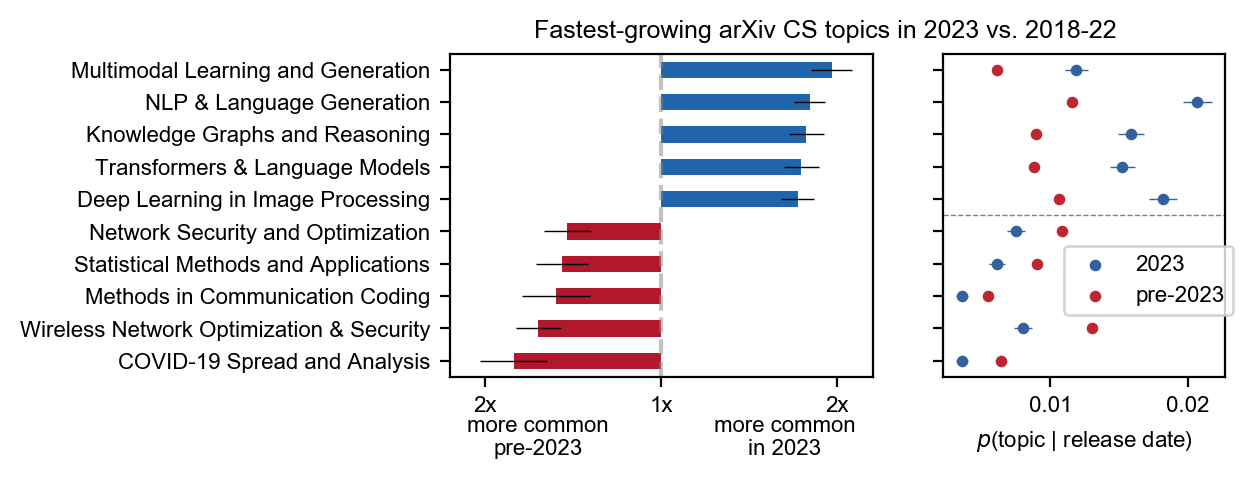

In [36]:
f, (enrich, dot) = utils.enrichment_plot_and_dotplot(
    recent_topic_df,
    bar_names_col='topic',
    neg_label='more common\npre-2023',
    pos_label='more common\nin 2023',
    true_label='2023',
    false_label='pre-2023',
    legend_coords=(0.39, 0.44),
    width_ratios=(3, 2),
    manual_enrichment_xlim=(1.2, 1.2),
    dotplot_xlabel=r'$p$(topic | release date)',
)

f.suptitle("Fastest-growing arXiv CS topics in 2023 vs. 2018-22", y=0.96, fontsize=9)
f.savefig('./analysis/figures/supp_topic_barplot_2023_growth_all_arxiv.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
# Display the sub-frame of topics in recent_topic_df with ratio > 1 and p_chi2 < 5e-4
recent_topic_df[(recent_topic_df['ratio'] > 1) & (recent_topic_df['p_chi2'] < 5e-4)]

,topic,ratio,count_true,count_false,p_topic_if_true,p_topic_if_false,p_chi2
52,Multimodal Learning and Generation,1.955956,"(807, 67864)","(2130, 350352)",0.011891,0.006080,1.160648e-61
54,NLP & Language Generation,1.793566,"(1406, 67864)","(4047, 350352)",0.020718,0.011551,1.450756e-82
39,Knowledge Graphs and Reasoning,1.768427,"(1078, 67864)","(3147, 350352)",0.015885,0.008982,1.051073e-60
94,Transformers & Language Models,1.735949,"(1035, 67864)","(3078, 350352)",0.015251,0.008785,7.139038e-55
24,Deep Learning in Image Processing,1.709320,"(1235, 67864)","(3730, 350352)",0.018198,0.010646,6.383479e-62
29,Federated Learning,1.624977,"(661, 67864)","(2100, 350352)",0.009740,0.005994,3.671204e-28
88,Speech and Gesture Synthesis,1.592192,"(264, 67864)","(856, 350352)",0.003890,0.002443,3.249113e-11
38,Interactive Visualization & AI Interaction,1.474522,"(850, 67864)","(2976, 350352)",0.012525,0.008494,7.320556e-24
55,NLP & Language Models,1.439380,"(1229, 67864)","(4408, 350352)",0.018110,0.012582,3.622002e-30
34,HCI and Explainable AI,1.380380,"(896, 67864)","(3351, 350352)",0.013203,0.009565,6.057698e-18


### Fastest growing unigrams/bigrams on arXiv cs/stat

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr

def compare_word_sets(d, language_col, binary_col, min_token_usage_cutoff, neg_downsample_frac=None):
    """
    Compare sets of words used by two different papers.
    d is df to use
    language_col is e.g. abstract or title; the column with the language you want to analyze
    binary_col is the column which dichotomizes the data
    min_token_usage_cutoff is the minimum number of times the token has to be used
    neg_downsample_frac can be used to downsample the negative class if there are few positives and a ton of negatives (just for speed)
    """
    vectorizer = CountVectorizer(min_df=min_token_usage_cutoff, stop_words='english', ngram_range=(1, 2))
    if neg_downsample_frac is not None:
        print("downsampling negative samples with fraction %2.3f" % neg_downsample_frac)
        idxs_to_keep = (d[binary_col] == True) | (np.random.random(len(d)) < neg_downsample_frac)
        d_to_use = d.loc[idxs_to_keep].copy()
    else:
        d_to_use = d.copy()
    X = vectorizer.fit_transform(d_to_use[language_col])
    M = X.toarray()
    assert d_to_use[binary_col].map(lambda x:x in [True, False]).all()
    M_pos = M[d_to_use[binary_col] == True, :]
    M_neg = M[d_to_use[binary_col] == False, :]
    assert len(M_pos) + len(M_neg) == len(d_to_use)
    pos_token_p = (M_pos > 0).mean(axis=0) 
    neg_token_p = (M_neg > 0).mean(axis=0) 
    unbinarized_pos_token_counts = M_pos.sum(axis=0)
    unbinarized_neg_token_counts = M_neg.sum(axis=0)
    pos_token_counts = (M_pos > 0).sum(axis=0)
    neg_token_counts = (M_neg > 0).sum(axis=0)
    pos_token_proportions = M_pos.sum(axis=0)/M_pos.sum() # fighting words definition of f_{kw}
    neg_token_proportions = M_neg.sum(axis=0)/M_neg.sum() # fighting words definition of f_{kw}. A bit weird cuz it's not disjoint. 
    results_df = pd.DataFrame({'token':vectorizer.get_feature_names_out(), 
                  'pos_token_p':pos_token_p, # fraction of positive papers using token 
                  'neg_token_p':neg_token_p, # fraction of negative papers using token
                  'pos_token_counts':pos_token_counts, # counts of token in positive papers
                  'neg_token_counts':neg_token_counts, # counts of token in negative papers
                  'pos_token_proportions':pos_token_proportions, 
                  'neg_token_proportions':neg_token_proportions,
                  'unbinarized p(pos|token)':unbinarized_pos_token_counts/(unbinarized_pos_token_counts + unbinarized_neg_token_counts), 
                  'fightin words log odds':(pos_token_proportions/(1 - pos_token_proportions))/(neg_token_proportions/(1 - neg_token_proportions)),
                  'p(token|pos)/p(token|neg)':pos_token_p/neg_token_p,
                  'unbinarized p(token|pos)/p(token|neg)':(M_pos.mean(axis=0))/(M_neg.mean(axis=0)),
                  'p(pos|token)':pos_token_counts/(pos_token_counts + neg_token_counts)})
    return results_df

def print_top_enriched_words(results_df, measure_to_sort_by, ascending, n_to_print, remove_stuff_only_used_in_one_cat=False):
    """
    given the output of compare_word_sets as results_df, print results in easy-to-skim form. 
    See emma-compare-words-used-in-two-sets.ipynb for sample useage. 
    """
    pd.set_option('display.width', 500)
    ranking_measures = ['p(pos|token)', 'fightin words log odds', 'unbinarized p(pos|token)']
    assert measure_to_sort_by in ranking_measures
    min_correlation = 1
    results_df = results_df.copy()
    for measure1 in ranking_measures:
        for measure2 in ranking_measures:
            if measure1 > measure2:
                spearman_corr = spearmanr(results_df[measure1], results_df[measure2])[0]
                min_correlation = min(min_correlation, spearman_corr)
    if remove_stuff_only_used_in_one_cat:
        old_len = len(results_df)
        results_df = results_df.loc[results_df['p(pos|token)'].map(lambda x:(x > 0) and (x < 1))].copy()
        print("removing words only used in one category: old length %i, new length %i" % (old_len, len(results_df)))
    top_words_d = {}
    print("The top %i enriched words (with ascending=%s) using each ranking measure are" % (n_to_print, ascending))
    for measure in ranking_measures:
        top_words = results_df.sort_values(by=measure, ascending=ascending)['token'].values[:n_to_print]
        top_words_d[measure] = top_words
    print(pd.DataFrame(top_words_d))
    print("Table with token counts, sorting by %s" % measure_to_sort_by)
    print(results_df.sort_values(by=measure_to_sort_by, ascending=ascending)[['token', 'pos_token_counts', 'neg_token_counts', 'p(pos|token)', 'p(token|pos)/p(token|neg)', 'unbinarized p(pos|token)', 'unbinarized p(token|pos)/p(token|neg)']].head(n=n_to_print))

In [7]:
results_df = compare_word_sets(metadata, language_col='abstract', binary_col='post_2023', min_token_usage_cutoff=100, neg_downsample_frac=0.2)
print_top_enriched_words(results_df, measure_to_sort_by='p(pos|token)', ascending=False, n_to_print=50)

downsampling negative samples with fraction 0.200


/tmp/ipykernel_3797918/1962187141.py:43: RuntimeWarning: divide by zero encountered in divide
  'fightin words log odds':(pos_token_proportions/(1 - pos_token_proportions))/(neg_token_proportions/(1 - neg_token_proportions)),
/tmp/ipykernel_3797918/1962187141.py:44: RuntimeWarning: divide by zero encountered in divide
  'p(token|pos)/p(token|neg)':pos_token_p/neg_token_p,
/tmp/ipykernel_3797918/1962187141.py:45: RuntimeWarning: divide by zero encountered in divide
  'unbinarized p(token|pos)/p(token|neg)':(M_pos.mean(axis=0))/(M_neg.mean(axis=0)),


The top 50 enriched words (with ascending=False) using each ranking measure are
               p(pos|token)   fightin words log odds unbinarized p(pos|token)
0        instruction tuning                model sam                model sam
1                 model sam             llms chatgpt             llms chatgpt
2              llms chatgpt       instruction tuning       instruction tuning
3                      2023                    llama                    llama
4                     llama                  chatgpt                  chatgpt
5                   chatgpt                     2023                     2023
6              like chatgpt             like chatgpt             like chatgpt
7                 llm based                llm based                llm based
8             segment model                     llms                     llms
9               models llms            segment model            segment model
10                     llms              models llms          

In [12]:
results_df.

Index(['token', 'pos_token_p', 'neg_token_p', 'pos_token_counts', 'neg_token_counts', 'pos_token_proportions', 'neg_token_proportions', 'unbinarized p(pos|token)', 'fightin words log odds', 'p(token|pos)/p(token|neg)', 'unbinarized p(token|pos)/p(token|neg)', 'p(pos|token)', 'ratio'], dtype='object')

In [14]:
# Print out top 50 keywords in a latex table with just two columns
# Column 1: Keyword, wrapped in \texttt{}
# Column 2: $\frac{p(\text{keyword} | \text{post-2023})}{p(\text{keyword} | \text{pre-2023})}$, rounded to 1 decimal place

results_df['ratio'] = results_df['pos_token_p']/results_df['neg_token_p']
latex_df = results_df.sort_values(by='ratio', ascending=False)[['token', 'ratio']].head(n=50).copy()
latex_df['ratio'] = latex_df['ratio'].map(lambda x:round(x, 1))
latex_df['token'] = latex_df['token'].map(lambda x:'\\texttt{%s}' % x)
latex_df.columns = ['Keyword', '$\\frac{p(\\text{keyword} | \\text{post-2023})}{p(\\text{keyword} | \\text{pre-2023})}$']
print(latex_df.to_latex(index=False, escape=False))

\begin{tabular}{lr}
\toprule
                         Keyword &  $\frac{p(\text{keyword} | \text{post-2023})}{p(\text{keyword} | \text{pre-2023})}$ \\
\midrule
     \texttt{instruction tuning} &                                                inf \\
              \texttt{model sam} &                                                inf \\
           \texttt{llms chatgpt} &                                                inf \\
                   \texttt{2023} &                                              189.4 \\
                  \texttt{llama} &                                              188.6 \\
                \texttt{chatgpt} &                                              179.8 \\
           \texttt{like chatgpt} &                                              132.6 \\
              \texttt{llm based} &                                               80.8 \\
          \texttt{segment model} &                                               73.1 \\
            \texttt{models llms} &     

/tmp/ipykernel_3797918/3185578918.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_df.to_latex(index=False, escape=False))
